# Ptychographic Reconstructions

Ptychography describes a family of reconstruction algorithms which attempt to find the object operator $\hat{O}_j = O_{\boldsymbol{r}-\boldsymbol{R}_j}$ and probe $\left| P \right \rangle$ state which reproduce measured diffraction intensities in the far-field:

$$
I_{j \boldsymbol{q}} = \left| \left \langle \boldsymbol{q} \right| \hat{O}_j \left| P \right \rangle \right|^2
$$

The ptychographic iterative engine (PIE) is an iterative technique which modifies the current exit wave $\psi_{j \boldsymbol{r}}$ estimate by replacing its Fourier amplitude with the square root of the measured diffraction intensity.

The three steps in the various different PIE formulations are given by:
1. Overlap-Projection Constraint, between Object(s) and Probe(s)
2. Fourier-Projection Constraint, between Exit-Wave and Measured Diffraction Intensities
3. Gradient-Descent Update for Object(s) and (optionally) Probe(s)

## Electrostatic Potential Reconstruction

In this tutorial, we use [regularized PIE](https://doi.org/10.1364/OPTICA.4.000736) to reconstruct the electrostatic potential of a crystalline sample.

More specifically, we wish to reconstruct the projected electrostatic potential contributions to the Aharonov-Bohm phase shift given by:

$$
\begin{align}
    \phi_e(\boldsymbol{r}_\bot) = \frac{e}{\hbar v}\int_L V(\boldsymbol{r}_{\bot},z) dz 
\end{align}
$$

We consider a (thin) slab of [110] STO:

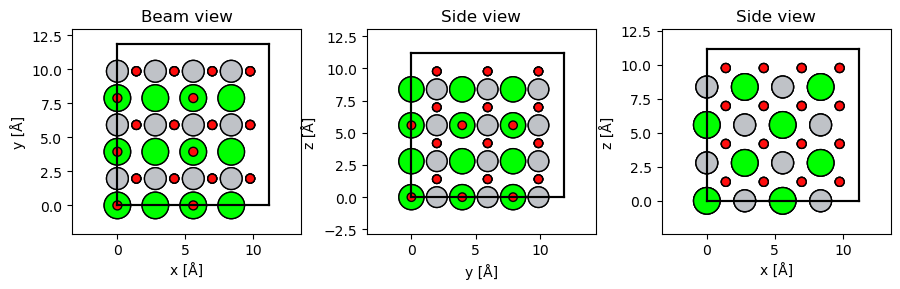

In [1]:
from ase.io import read
from ase import Atoms
from ase.build import surface
from matplotlib import pyplot as plt

STO_unit_cell = read("../data/SrTiO3.cif")
STO_atoms = surface(STO_unit_cell, (1, 1, 0), 4, periodic=True) * (2, 3, 1)

from abtem import show_atoms

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))

show_atoms(STO_atoms, ax=ax1, title="Beam view")
show_atoms(STO_atoms, ax=ax2, plane="yz", title="Side view")
show_atoms(STO_atoms, ax=ax3, plane="xz", title="Side view")

fig.tight_layout();

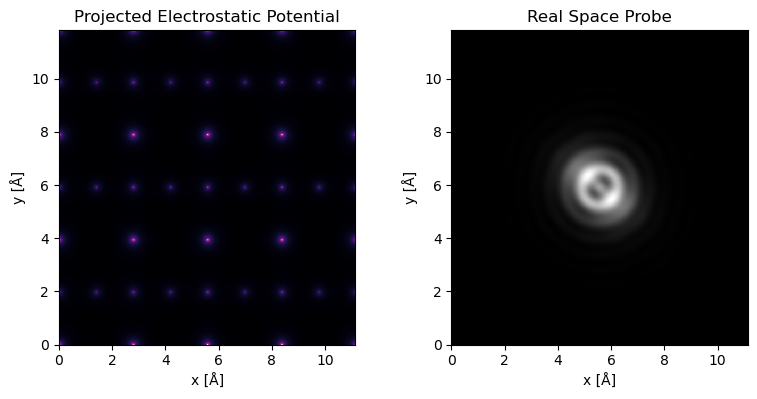

In [2]:
from abtem import Potential
from abtem import CTF, Probe

electrostatic_potential = Potential(
    STO_atoms,
    sampling=0.02,
    device="gpu",
    projection="infinite",
    parametrization="kirkland",
).build()


ctf = CTF(
    parameters={"C10": -75, "C12": 10, "phi12": 0.785}, semiangle_cutoff=24
)
probe = Probe(semiangle_cutoff=24, energy=200e3, ctf=ctf, device="gpu")
probe.match_grid(electrostatic_potential)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
electrostatic_potential.project().show(
    cmap="magma", figsize=(4, 4), title="Projected Electrostatic Potential", ax=ax1
)
probe.show(figsize=(4, 4), title="Real Space Probe", ax=ax2)
fig.tight_layout()

We perform the 4DSTEM simulation and check how our HAADF looks like: 

Scan:   0%|          | 0/483 [00:00<?, ?it/s]

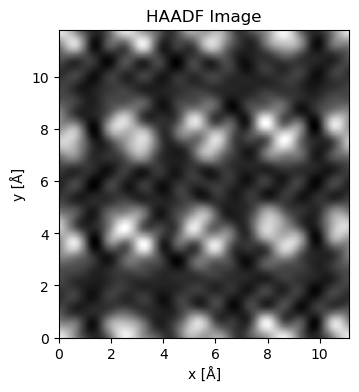

In [3]:
from abtem.detect import AnnularDetector, PixelatedDetector
from abtem.scan import GridScan
from abtem.noise import poisson_noise

pixelated_detector = PixelatedDetector(max_angle=120)
gridscan = GridScan(
    (0, 0), electrostatic_potential.extent, sampling=2 * probe.ctf.nyquist_sampling
)
measurement = probe.scan(gridscan, pixelated_detector, electrostatic_potential)
noisy_measurement = poisson_noise(measurement, 1e6)

haadf_detector_measurement = AnnularDetector(inner=24, outer=120).integrate(
    noisy_measurement
)
haadf_detector_measurement = haadf_detector_measurement.interpolate(
    electrostatic_potential.sampling
)

haadf_detector_measurement.show(figsize=(4, 4), title="HAADF Image");

We start by importing the `RegularizedPtychographicOperator` object from `abtem.reconstruct`.  
This has various options, but at the very least needs to be initialized using:  
- A `Measurement` object (or array dirrectly) representing the set of diffraction intensities  
- The `energy` the experiment was carried out and the `semiangle_cutoff` for our initial probe-guess  
  - We could also pass `defocus` and other aberrations aswell - but one of the strengths of r-PIE is reconstructing the probe aberrations, so we deliberately omit these  
  
_Note:_ The initialization further accepts a parameters dictionary, with the properties below pertaining to the simulation/experimental conditions.  
If you're passing a `Measurement` object, most of these will be automatically detected, but here we specify `object_px_padding:(0,0)` to indicate we're interested in a periodic reconstruction.

In [4]:
from abtem.reconstruct import experimental_symbols, reconstruction_symbols

experimental_symbols

('rotation_angle',
 'scan_step_sizes',
 'angular_sampling',
 'background_counts_cutoff',
 'counts_scaling_factor',
 'grid_scan_shape',
 'object_px_padding')

The object then exposes two main methods:
1. `preprocess()`, which prepares the reconstruction
2. `reconstruct()`, which performs the ptychographic reconstruction using the requested reconstruction parameters.  

_Note:_ There's a lot of hyper-parameters (such as update step sizes and regularization) one could tune here, but the default values below perform reasonably well for demonstration

In [5]:
reconstruction_symbols

{'alpha': 1.0,
 'beta': 1.0,
 'object_step_size': 1.0,
 'probe_step_size': 1.0,
 'position_step_size': 1.0,
 'step_size_damping_rate': 0.995,
 'pre_position_correction_update_steps': None,
 'pre_probe_correction_update_steps': None,
 'pure_phase_object_update_steps': None,
 'probe_support_relative_radius': 1.0,
 'probe_support_supergaussian_degree': 10.0}

In [6]:
from abtem.reconstruct import RegularizedPtychographicOperator

electrostatic_potential_ptycho_operator = RegularizedPtychographicOperator(
    noisy_measurement,
    semiangle_cutoff=24,
    energy=200e3,
    device="gpu",
    defocus=75,
    parameters={"object_px_padding": (0, 0)},
).preprocess()

(
    rpie_objects,
    rpie_probes,
    rpie_positions,
    rpie_sse,
) = electrostatic_potential_ptycho_operator.reconstruct(
    max_iterations=5, random_seed=1, verbose=True, return_iterations=True
)

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 2415 steps
--Probe correction is enabled


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/483 [00:00<?, ?it/s]

----Iteration 0, SSE = 9.613e-07
----Iteration 1, SSE = 6.127e-07
----Iteration 2, SSE = 6.040e-07
----Iteration 3, SSE = 6.005e-07
----Iteration 4, SSE = 5.989e-07


_Note:_ Since we specified `verbose=True`, the reconstruction prints the steps it will take, as-well as the error of each iteration.

Let's investigate our reconstructed object and probe:

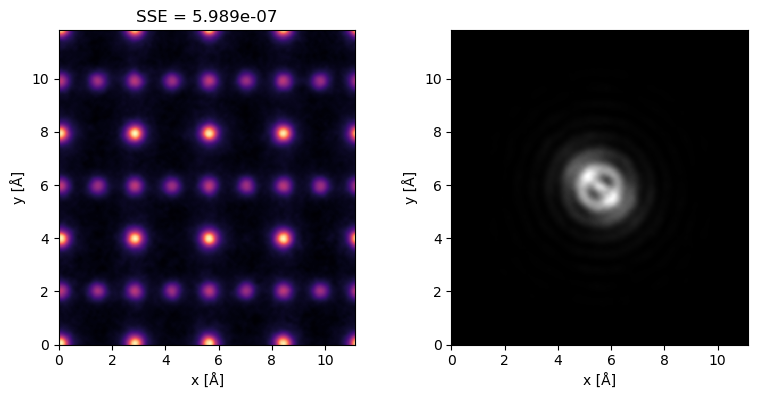

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
rpie_objects[-1].angle().interpolate(electrostatic_potential.sampling).show(
    ax=ax1, cmap="magma", title=f"SSE = {float(rpie_sse[-1]):.3e}"
)
rpie_probes[-1].intensity().interpolate(electrostatic_potential.sampling).show(ax=ax2)
fig.tight_layout()

This is quite good, considering our significant aberrations and noisy measurement, the regularized-PIE algorithm is effectively converged after only a couple of iterations and has identified most aberrations!